# Random Forest Classification

## 1. Veri Hazırlama ve Temizleme

Bu bölümde, gerekli Python kütüphaneleri yüklenir, veri seti okunur ve temizleme işlemleri uygulanır.  
Özetle:
- Eksik müşteri kimlikleri içeren satırlar kaldırılır.
- Toplam harcama hesaplanır.
- Geçersiz miktarlar filtrelenir.
- Fatura tarihleri datetime formatına dönüştürülür.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

# Veri Setini Yükleme
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url, sheet_name="Online Retail")

# Veri Temizleme
df = df.dropna(subset=["CustomerID"])
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df = df[df["Quantity"] > 0]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [2]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## 2. Özellik (Feature) Mühendisliği ve Churn Tanımlama

Bu bölümde, müşteri düzeyinde özet veriler oluşturulur.  
Özetle:
- Ülke degiskeninin sayisal degil kategorik olarak tanimlanmasi yapilir.
- Müşterilere ait toplam harcama, sipariş sayısı, ortalama sipariş değeri gibi metrikler hesaplanır.
- Her müşteri için benzersiz ülke sayısı, son satın alma tarihi ve son satın alma yıl-ay bilgileri belirlenir.
- Son 6 ay içerisinde alışveriş yapmayan müşteriler churn (müşteri kaybı) olarak tanımlanır.

In [3]:
# 'Country' Kodlamasi
encoder = LabelEncoder()
df["Country_Encoded"] = encoder.fit_transform(df["Country"])

# Müşteri Düzeyinde Verileri Toplama
customer_data = df.groupby("CustomerID").agg(
    TotalSpend=("TotalPrice", "sum"),
    OrderCount=("InvoiceNo", "nunique"),
    AvgOrderValue=("TotalPrice", "mean"),
    Country=("Country_Encoded", "first"),
    LastPurchase=("InvoiceDate", "max")
).reset_index()

# Churn Tanımlama
latest_date = df["InvoiceDate"].max()
customer_data["Churn"] = (latest_date - customer_data["LastPurchase"]).dt.days > 180
customer_data["Churn"] = customer_data["Churn"].astype(int) # binary ye cevirme
customer_data = customer_data.drop(columns=["LastPurchase"])


## 3. Model Eğitimi ve Optimizasyonu

Bu bölümde, makine öğrenmesi modeli için özellikler (features) ve hedef (target) belirlenir.  
Özetle:
- Müşteri verilerinden modelin eğitimi için kullanılacak özellikler ve hedef değişken tanımlanır.
- Sayısal özellikler standardizasyon işlemine tabi tutulur.
- Eğitim ve test verileri ayrılır.
- Random Forest modelinin hiperparametreleri için bir parametre ızgarası tanımlanır.
- RandomizedSearchCV kullanılarak en iyi hiperparametreler bulunur ve model eğitilir.

In [4]:
# Makine Öğrenmesi için Features ve Target Tanımlama
X_clf = customer_data[["TotalSpend", "OrderCount", "AvgOrderValue", "Country"]].copy()
y_clf = customer_data["Churn"]

# Sayısal Özelliklerin Standardizasyonu
numeric_features = ["TotalSpend", "OrderCount", "AvgOrderValue"]
scaler = StandardScaler()
X_clf[numeric_features] = scaler.fit_transform(X_clf[numeric_features])

# Eğitim ve Test Verilerinin Ayrılması
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Parametre Grid Tanımlama
param_grid_clf = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

# Rastgele Arama ile En İyi Parametrelerin Bulunması
rf_clf_opt = RandomForestClassifier(random_state=42)
random_search_clf = RandomizedSearchCV(rf_clf_opt, param_grid_clf, n_iter=20, cv=5, scoring="accuracy", random_state=42)
random_search_clf.fit(X_train_clf, y_train_clf)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [5, 10, 20, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=42, scoring='accuracy')

## 4. Model Değerlendirme ve Sonuçlar

Bu bölümde, optimize edilmiş model kullanılarak tahminler yapılır ve model performansı değerlendirilir.  
Özetle:
- En iyi model seçilerek test verileri üzerinde tahminler yapılır.
- Modelin doğruluk oranı, sınıflandırma raporu gibi metrikler hesaplanır.
- Önemli özelliklerin (feature) model içindeki katkıları görselleştirilir.
- Bu model, tedarik zinciri yönetiminde müşteri kaybını öngörmek, kampanya stratejilerini optimize etmek gibi uygulamalarda kullanılabilir.

In [5]:
# En İyi Modelin Seçilmesi
best_rf_clf = random_search_clf.best_estimator_
print("Best Hyperparameters:", random_search_clf.best_params_)

Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5}


In [6]:
# Tahmin ve Değerlendirme
y_pred_best_clf = best_rf_clf.predict(X_test_clf)
accuracy_best = accuracy_score(y_test_clf, y_pred_best_clf)

print(f"Optimized Random Forest Classification Accuracy: {accuracy_best:.2%}")
print("Optimized Classification Report:\n", classification_report(y_test_clf, y_pred_best_clf))

Optimized Random Forest Classification Accuracy: 80.99%
Optimized Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.89       703
           1       0.50      0.05      0.09       165

    accuracy                           0.81       868
   macro avg       0.66      0.52      0.49       868
weighted avg       0.76      0.81      0.74       868



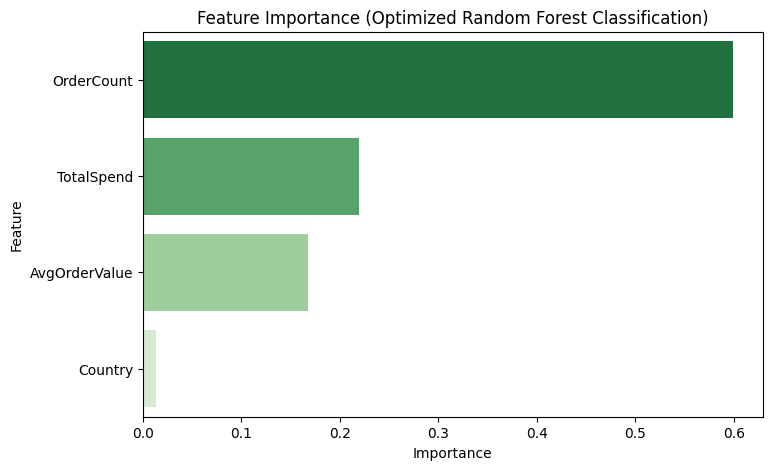

In [7]:
# Önemli Özelliklerin Belirlenmesi ve Görselleştirilmesi
feature_importance_clf = pd.DataFrame({
    "Feature": X_clf.columns,
    "Importance": best_rf_clf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_clf, hue="Feature", palette="Greens_r", legend=False)
plt.title("Feature Importance (Optimized Random Forest Classification)")
plt.show()